# Introduction
Inspired by [Maria Movin (2018)](http://www.nada.kth.se/~ann/exjobb/maria_movin.pdf) I want to attempt to perform spelling correction using a machine translation model.
She uses a very similar model to what I used in `1. Machine Translation - Character Level Model`.

I will attempt to use a similar model, but will also try to use an embedding layer for the characters.
Perhaps the model could learn similarities between some characters?

# Data
I will be using the [Twitter Typo](http://luululu.com/tweet/) data set to train and evaluate my model.
It consists of 39 172 misspelled words and their correct spelling, including some meta data about what type of misspelling it is.
This data set was used by [Gosh and Kristensson (2015)](https://arxiv.org/pdf/1709.06429.pdf) to learn about common spelling mistakes in order to generate a larger data set of corrected words.
As I am running my model on my weak laptop I will opt to not extend the data set.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## Import the Data

In [3]:
data_path = 'data/twitter_typos/typo-corpus-r1.txt'
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

rows = []
for line in lines:
    rows.append(line.split('\t')[:3])
    

In [4]:
rows[0]

['york', 'work', 'R2']

In [5]:
rows[-1]

['']

In [6]:
rows = rows[:-1]

In [7]:
df = pd.DataFrame(data=rows, columns=['incorrect', 'correct', 'type'])

In [8]:
df.head()

,incorrect,correct,type
0,york,work,R2
1,prople,people,R2
2,hring,hiring,RM
3,prople,people,R2
4,prople,people,R2


In [9]:
df.shape

(39172, 3)

Add a begginging of word and end of word character to all targets, this will be used to seed new words and determine where a word ends. 
I will use `\t` as start of word and `\n` as end of word characters.

In [10]:
df['correct'] = df['correct'].apply(lambda x: '\t' + x + '\n' )

The four kind of types are:
1. INSERT (IN): a character is added to the original word.
2. REMOVE (RM): a character is removed from the original word.
3. REPLACE1 (R1): the order of character is different from the original word (the number of differences is one).
4. REPLACE2 (R2): a character is different from the original word.

## Explore the data

### Types of Misspellings

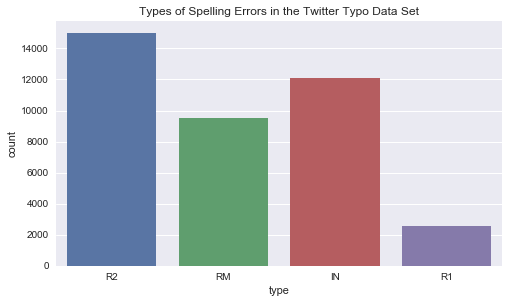

In [11]:
f, ax = plt.subplots(figsize=(8,4.5))
sns.countplot(x='type', data=df)
ax.set_title('Types of Spelling Errors in the Twitter Typo Data Set')

### Number of duplicates

In [12]:
print("Distinct incorrect words: {}".format(df['incorrect'].nunique()))
print("Distinct correct words: {}".format(df['correct'].nunique()))

Distinct incorrect words: 9294
Distinct correct words: 2466


### Missing data

In [13]:
df.isnull().sum()

incorrect    0
correct      0
type         0
dtype: int64

### Number of Unique Characters

In [14]:
def add_char(word):
    for c in word:
        chars.add(c)
chars = set()
df['incorrect'].apply(add_char);
df['correct'].apply(add_char);

In [15]:
len(chars)

29

### Word Length

In [16]:
df['incorrect'].apply(len).describe()

count    39172.000000
mean         4.124553
std          2.088488
min          1.000000
25%          3.000000
50%          3.000000
75%          5.000000
max         16.000000
Name: incorrect, dtype: float64

In [17]:
df['correct'].apply(len).describe()

count    39172.000000
mean         6.058128
std          2.173799
min          2.000000
25%          4.000000
50%          6.000000
75%          7.000000
max         17.000000
Name: correct, dtype: float64

In [18]:
max_input_len = df['incorrect'].apply(len).max()
max_output_len = df['correct'].apply(len).max()

## Encode Characters as Integers
I will encode all characters as integers to make them compatible with the Keras Embedding layer. I keep `0` for padding.
All words will be coverted into lists of integers.

In [19]:
vocab_size = len(chars)

In [20]:
char_mapping = dict(zip(sorted(list(chars)), np.arange(1, vocab_size+1)))
reversed_char_mapping = dict([(b, a) for a, b in char_mapping.items()])

In [21]:
reversed_char_mapping[0] = '<pad>'

In [22]:
df['X'] = df['incorrect'].apply(lambda x: [char_mapping[c] for c in x])
df['y'] = df['correct'].apply(lambda x: [char_mapping[c] for c in x])

## Divide data into training, dev and test set
When splitting the data into different sets I will be using `type` to strattify the data.
I think it is a good idea to make sure that all sets are representable of all types of errors.

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
df_train, df_test = train_test_split(df, stratify=df['type'], test_size=1/10, random_state=1)
df_train, df_dev = train_test_split(df_train, stratify=df_train['type'], test_size=(2/9), random_state=1)

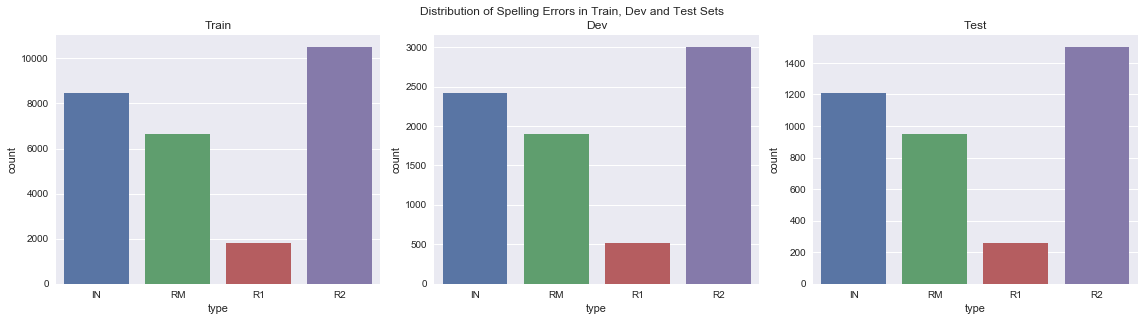

In [22]:
f, ax = plt.subplots(1, 3, figsize=(16,4.5))
for i, name, dfi in zip(np.arange(3), ["Train", "Dev", "Test"], [df_train, df_dev, df_test]):
    sns.countplot(data=dfi, x='type', ax=ax[i], order=['IN', 'RM', 'R1', 'R2'])
    ax[i].set_title(name)
f.tight_layout(rect = [0, 0, 1, .97])
f.suptitle("Distribution of Spelling Errors in Train, Dev and Test Sets")

In [25]:
X_train, y_train = df_train['X'].values, df_train['y'].values
X_dev, y_dev = df_dev['X'].values, df_dev['y'].values
X_test, y_test = df_test['X'].values, df_test['y'].values

## Pad Data
To allow a Keras RNN to process data in batches the whole batces all sequences in one batch needs to be the same length.
This is acheived by padding sentences with trailing `0`'s that will be ignored during training. 

To avoid padding all sentences to be as long as the longest sentence in each set I will sort the data sets.

In [26]:
sorted_idx_train = np.argsort(list(map(lambda x: len(x), X_train)))
sorted_idx_dev = np.argsort(list(map(lambda x: len(x), X_dev)))
sorted_idx_test = np.argsort(list(map(lambda x: len(x), X_test)))

In [27]:
X_train = X_train[sorted_idx_train]
y_train = y_train[sorted_idx_train]
df_train = df_train.iloc[sorted_idx_train]

X_dev = X_dev[sorted_idx_dev]
y_dev = y_dev[sorted_idx_dev]
df_dev = df_dev.iloc[sorted_idx_dev]

X_test = X_test[sorted_idx_test]
y_test = y_test[sorted_idx_test]
df_test = df_test.iloc[sorted_idx_test]

Generator for the padded sequences.

In [28]:
def one_hot(i, n):
    arr = np.zeros(n)
    arr[i] = 1
    return arr

In [29]:
from keras.utils import Sequence
from keras.preprocessing.sequence import pad_sequences
class ShortPaddingGeneratorSeq2Seq(Sequence):
    """
    Class for generating padded sequences
    """
    def __init__(self, x_set, y_set, batch_size, return_sample_weights=True, one_hot_encode=False):
        self.return_sample_weights = return_sample_weights
        self.batch_size = batch_size
        self.x, self.y, self.sample_weights = [], [], []
        self.x2 = []
        # Pad Data so all batches have sequences of equal length
        for idx in range(int(np.ceil(len(x_set) / float(self.batch_size)))):
            batch_x = x_set[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_y = y_set[idx * self.batch_size:(idx + 1) * self.batch_size]
            
            # The input is sorted so the last sequence is the longest
            max_len_x = len(batch_x[-1])
            max_len_y = len(batch_y[-1])
            batch_x = np.array(pad_sequences(batch_x, maxlen=max_len_x, padding='post'))
            batch_y = np.array(pad_sequences(batch_y, maxlen=max_len_y, padding='post'))
            
            #self.sample_weights.append(batch_x != 0)
            self.sample_weights.append(batch_y[:,1:] != 0)
            
            if one_hot_encode:
                batch_x = np.array([np.array([one_hot(i, vocab_size+1) for i in sentence]) for sentence in batch_x])
                batch_y = np.array([np.array([one_hot(i, vocab_size+1) for i in sentence]) for sentence in batch_y])
            
            self.x.append(batch_x)
            self.y.append(batch_y[:,1:])
            # The decoder input s
            self.x2.append(batch_y[:,:-1])
            
            
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        # Fetch the batches
        if self.return_sample_weights:
            return [self.x[idx], self.x2[idx]], self.y[idx], self.sample_weights[idx]
        else:
            return [self.x[idx], self.x2[idx]], self.y[idx]
    
    def set_return_sample_weights(self, flag):
        self.return_sample_weights = flag

Using TensorFlow backend.


Create the generators for each set.

In [28]:
train_gen = ShortPaddingGeneratorSeq2Seq(X_train, y_train, batch_size=64, one_hot_encode=True)
dev_gen = ShortPaddingGeneratorSeq2Seq(X_dev, y_dev, batch_size=64, one_hot_encode=True)
test_gen = ShortPaddingGeneratorSeq2Seq(X_test, y_test, batch_size=64, one_hot_encode=True)

In [29]:
print(train_gen[100][0][0].shape)
print(train_gen[100][0][1].shape)
print(train_gen[100][1].shape)


(64, 2, 30)
(64, 3, 30)
(64, 3, 30)


# One-Hot Encoded Characters
First let's use the model proposed in Francois Chollet's article [A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html).

In [30]:
# Config
batch_size = 64
latent_dim = 256

In [31]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define the encoder to have one hidden LSTM layer and output its state
encoder_inputs = Input(shape=(None, vocab_size+1))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# Only save the states of the encoder, we don't care about it's output
encoder_states = [state_h, state_c]

# Define the decoder, it will use the state of the encoder as its initial state
decoder_inputs = Input(shape=(None, vocab_size+1))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(vocab_size+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [136]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [137]:
# Run training
model.compile(optimizer='adam', loss='categorical_crossentropy', weighted_metrics=['accuracy'], sample_weight_mode="temporal")

In [181]:
model.fit_generator(train_gen,
          epochs=10,
          validation_data=dev_gen)

Epoch 1/10
429/429 [==============================] - 45s 105ms/step - loss: 0.3171 - weighted_acc: 0.9044 - val_loss: 0.3307 - val_weighted_acc: 0.9021
Epoch 2/10
429/429 [==============================] - 50s 117ms/step - loss: 0.2635 - weighted_acc: 0.9201 - val_loss: 0.3003 - val_weighted_acc: 0.9102
Epoch 3/10
429/429 [==============================] - 50s 116ms/step - loss: 0.2311 - weighted_acc: 0.9286 - val_loss: 0.2964 - val_weighted_acc: 0.9081
Epoch 4/10
429/429 [==============================] - 52s 120ms/step - loss: 0.2088 - weighted_acc: 0.9351 - val_loss: 0.2982 - val_weighted_acc: 0.9105
Epoch 5/10
429/429 [==============================] - 52s 121ms/step - loss: 0.1963 - weighted_acc: 0.9380 - val_loss: 0.2754 - val_weighted_acc: 0.9185
Epoch 6/10
429/429 [==============================] - 54s 126ms/step - loss: 0.1776 - weighted_acc: 0.9435 - val_loss: 0.2750 - val_weighted_acc: 0.9192
Epoch 7/10
429/429 [==============================] - 56s 131ms/step - loss: 0.168

# Inference

Let's test the model with Chollet's inference model.

In [182]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [183]:
max_decoder_seq_length = 20
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, vocab_size + 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char_mapping['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        #print(output_tokens)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reversed_char_mapping[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, vocab_size + 1))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [198]:
np.random.seed(1)
for seq_index in np.random.randint(0, len(X_train), 10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = X_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(np.array([np.array([one_hot(i, vocab_size+1) for i in input_seq])]))
    print('-')
    print('Input word:', df_train.iloc[seq_index]['incorrect'])
    print('Target word:', df_train.iloc[seq_index]['correct'].strip())
    print('Corrected word:', decoded_sentence)

-
Input word: yu
Target word: you
Corrected word: you

-
Input word: meg
Target word: me
Corrected word: me

-
Input word: im
Target word: i
Corrected word: i

-
Input word: forr
Target word: for
Corrected word: or

-
Input word: hav
Target word: has
Corrected word: a

-
Input word: tha
Target word: the
Corrected word: a

-
Input word: tqake
Target word: take
Corrected word: a

-
Input word: gottan
Target word: gotta
Corrected word: on

-
Input word: nw
Target word: now
Corrected word: on

-
Input word: goona
Target word: gonna
Corrected word: on



The model has learned some patterns, but seems to often resort to outputting short and simple words.

# Simpler Model - Single RNN
I want to try setting up a model that just uses a single RNN, instead of the decoder encoder model.
As I really like Embeddings, I will include an imbedding layer!

## Pad the Data
It seems like it's not straight forward to implement a RNN with input sequences of length `N` and output sequences of length `M` when `N!=M`.
Instead I will limit my model by setting a fixed input and output length and pad all sequences to be this length.

My model will not be able to handle targets longer than this limit, and will always produce outputs of exactly that length which I will have to terminate at the stop character `\n`.

Also, since I won't know the length of target words in a real use case, I don't want to process my data in batches of similar size. 
All inputs should generate output sequences of the exact same length.

In [32]:
max_len = max(max_input_len, max_output_len)
print(max_len)

17


First let's remove the start of word token from the outputs as it is not necessary in this model.

In [33]:
y_train_stripped = [seq[1:] for seq in y_train]
y_dev_stripped = [seq[1:] for seq in y_dev]
y_test_stripped = [seq[1:] for seq in y_test]

In [34]:
X_train_padded = np.array(pad_sequences(X_train, maxlen=max_len, padding='post'))
y_train_padded = np.array(pad_sequences(y_train_stripped, maxlen=max_len, padding='post'))
X_dev_padded = np.array(pad_sequences(X_dev, maxlen=max_len, padding='post'))
y_dev_padded = np.array(pad_sequences(y_dev_stripped, maxlen=max_len, padding='post'))
X_test_padded = np.array(pad_sequences(X_test, maxlen=max_len, padding='post'))
y_test_padded = np.array(pad_sequences(y_test_stripped, maxlen=max_len, padding='post'))

This time I am not doing one hot encoding of the input, instead I will use an Embeddings layer. I will still one hot encode the outputs.

In [35]:
y_train_padded = np.array([np.array([one_hot(i, vocab_size+1) for i in sentence]) for sentence in y_train_padded])
y_dev_padded = np.array([np.array([one_hot(i, vocab_size+1) for i in sentence]) for sentence in y_dev_padded])
y_test_padded = np.array([np.array([one_hot(i, vocab_size+1) for i in sentence]) for sentence in y_test_padded])

## Set up the Model

In [36]:
from keras.layers import Embedding, Input, Dropout
from keras.callbacks import History

In [37]:
vocab_size

29

Our vocab size is 29. I have no idea what number embedding dimensions is suitable, so let's just embed these 29 characters into 10 dimensions. 

In [38]:
embedding_dim = 10

In [121]:
model_input = Input(shape=(None,))
embedding = Embedding(vocab_size+1, embedding_dim, mask_zero = True)(model_input)
x = Dropout(rate=.25)(embedding)
x = LSTM(latent_dim, return_sequences=True)(x)
model_output = Dense(vocab_size + 1, activation='softmax')(x)
simple_rnn1 = Model(model_input, model_output)

In [122]:
simple_rnn1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
callback = simple_rnn1.fit(X_train_padded, y_train_padded,
          epochs=2,
          validation_data=[X_dev_padded, y_dev_padded],
          callbacks = [History()])

Train on 27419 samples, validate on 7835 samples
Epoch 1/2
27419/27419 [==============================] - 120s 4ms/step - loss: 2.1676 - acc: 0.3967 - val_loss: 1.5059 - val_acc: 0.5982
Epoch 2/2
27419/27419 [==============================] - 135s 5ms/step - loss: 1.4863 - acc: 0.5987 - val_loss: 1.2422 - val_acc: 0.6626


Training time significantly increased now that all sequences are of equal length.

In [39]:
def decode_int_sequence(sequence):
    word = ""
    for token_index in sequence:
        c = reversed_char_mapping[token_index]
        if c not in ('\n', '<pad>'):
            word += c
        else:
            break
    return word

def evaluate_model(model, X, y, pred_idx):
    
    # Make predictions
    predictions = model.predict(X[pred_idx])
    
    # Print evaluation
    for idx, pred in zip(pred_idx, predictions):
        print("Input: ", decode_int_sequence(X[idx]))
        print("Target: ",decode_int_sequence(y[idx].argmax(1)))
        print("Output: ", decode_int_sequence(pred.argmax(1)))
        print("")

In [130]:
np.random.seed(1)
evaluate_model(simple_rnn1, X_train_padded, y_train_padded, np.random.randint(0, len(X_train), 5))

Input:  yu
Target:  you
Output:  yoooooooooooooooo

Input:  meg
Target:  me
Output:  meggggggggggggggg

Input:  im
Target:  i
Output:  issssssssssssssss

Input:  forr
Target:  for
Output:  for

Input:  hav
Target:  has
Output:  havvvvvvvvvvvvvvv



Cool, the model has already learned some stuff and actually got `forr` -> `for` right!
Let's allow it some more training, this time with shuffled batches and a set batch size.

In [134]:
callback = simple_rnn1.fit(X_train_padded, y_train_padded,
          epochs=10,
          batch_size = 128,
          shuffle = True,
          validation_data=[X_dev_padded, y_dev_padded],
          callbacks = [History()])

Train on 27419 samples, validate on 7835 samples
Epoch 1/10
27419/27419 [==============================] - 84s 3ms/step - loss: 1.2488 - acc: 0.6681 - val_loss: 1.1364 - val_acc: 0.6906
Epoch 2/10
27419/27419 [==============================] - 96s 3ms/step - loss: 1.2076 - acc: 0.6782 - val_loss: 1.1132 - val_acc: 0.6977
Epoch 3/10
27419/27419 [==============================] - 94s 3ms/step - loss: 1.1760 - acc: 0.6862 - val_loss: 1.0889 - val_acc: 0.7013
Epoch 4/10
27419/27419 [==============================] - 94s 3ms/step - loss: 1.1462 - acc: 0.6933 - val_loss: 1.0742 - val_acc: 0.7078
Epoch 5/10
27419/27419 [==============================] - 96s 4ms/step - loss: 1.1163 - acc: 0.7023 - val_loss: 1.0550 - val_acc: 0.7107
Epoch 6/10
27419/27419 [==============================] - 95s 3ms/step - loss: 1.0882 - acc: 0.7091 - val_loss: 1.0382 - val_acc: 0.7153
Epoch 7/10
27419/27419 [==============================] - 94s 3ms/step - loss: 1.0645 - acc: 0.7166 - val_loss: 1.0214 - val_acc:

In [146]:
np.random.seed(1)
evaluate_model(simple_rnn1, X_train_padded, y_train_padded, np.random.randint(0, len(X_train), 5))

Input:  yu
Target:  you
Output:  yoooooooooooooooo

Input:  meg
Target:  me
Output:  me

Input:  im
Target:  i
Output:  issssssssssssssss

Input:  forr
Target:  for
Output:  for

Input:  hav
Target:  has
Output:  havvvvvvvvvvvvvvv



In [145]:
simple_rnn1.save('keras_models/spell_correction_simple_rnn1.h5')

The model get's one more word right this time! `meg` -> `me`!

It produces many funny looking output like `havvvvvvvvvvvvvvv`. 
I think this might be due to me using `mask_zero` in the Embedding layer, and no sample weights. 
This means I am ignoring the characters being output when the input character is padding. 
I should try to use sample weights instead.

## Simpel model number two
Let's use sample weights instead of mask_zero in the embedding.

In [40]:
model_input = Input(shape=(None,))
embedding = Embedding(vocab_size+1, embedding_dim, mask_zero = False)(model_input)
x = Dropout(rate=.25)(embedding)
x = LSTM(latent_dim, return_sequences=True)(x)
model_output = Dense(vocab_size + 1, activation='softmax')(x)
simple_rnn2 = Model(model_input, model_output)

In [41]:
simple_rnn2.compile(optimizer='adam', loss='categorical_crossentropy', sample_weight_mode='temporal', weighted_metrics=['accuracy'])

In [42]:
y_train_sample_wights = y_train_padded[:,:,1:].any(2)
y_dev_sample_wights = y_dev_padded[:,:,1:].any(2)
y_test_sample_wights = y_test_padded[:,:,1:].any(2)

In [43]:
callback = simple_rnn2.fit(X_train_padded, y_train_padded, 
          sample_weight=y_train_sample_wights,
          epochs=2,
          validation_data=[X_dev_padded, y_dev_padded, y_dev_sample_wights], 
          callbacks = [History()])

Train on 27419 samples, validate on 7835 samples
Epoch 1/2
27419/27419 [==============================] - 132s 5ms/step - loss: 2.0710 - weighted_acc: 0.4243 - val_loss: 1.3744 - val_weighted_acc: 0.6290
Epoch 2/2
27419/27419 [==============================] - 127s 5ms/step - loss: 1.3535 - weighted_acc: 0.6301 - val_loss: 1.0565 - val_weighted_acc: 0.7118


In [44]:
np.random.seed(1)
evaluate_model(simple_rnn2, X_train_padded, y_train_padded, np.random.randint(0, len(X_train), 10))

Input:  yu
Target:  you
Output:  you

Input:  meg
Target:  me
Output:  meg

Input:  im
Target:  i
Output:  is

Input:  forr
Target:  for
Output:  fore

Input:  hav
Target:  has
Output:  hav

Input:  tha
Target:  the
Output:  the

Input:  tqake
Target:  take
Output:  thekk

Input:  gottan
Target:  gotta
Output:  got

Input:  nw
Target:  now
Output:  now

Input:  goona
Target:  gonna
Output:  goonle



Wow, using sample weights based on the targets instead of the inputs really shows results. 
The model has learned a lot of the words in the training set after just two epochs.
Let's give it some more training time!

In [45]:
callback = simple_rnn2.fit(X_train_padded, y_train_padded, 
          sample_weight=y_train_sample_wights,
          epochs=10,
          batch_size = 128,
          shuffle = True,
          validation_data=[X_dev_padded, y_dev_padded, y_dev_sample_wights], 
          callbacks = [History()])

Train on 27419 samples, validate on 7835 samples
Epoch 1/10
27419/27419 [==============================] - 83s 3ms/step - loss: 1.1861 - weighted_acc: 0.6775 - val_loss: 1.0024 - val_weighted_acc: 0.7266
Epoch 2/10
27419/27419 [==============================] - 84s 3ms/step - loss: 1.1421 - weighted_acc: 0.6891 - val_loss: 0.9705 - val_weighted_acc: 0.7350
Epoch 3/10
27419/27419 [==============================] - 82s 3ms/step - loss: 1.0993 - weighted_acc: 0.7009 - val_loss: 0.9401 - val_weighted_acc: 0.7425
Epoch 4/10
27419/27419 [==============================] - 81s 3ms/step - loss: 1.0595 - weighted_acc: 0.7129 - val_loss: 0.9123 - val_weighted_acc: 0.7515
Epoch 5/10
27419/27419 [==============================] - 82s 3ms/step - loss: 1.0298 - weighted_acc: 0.7209 - val_loss: 0.8917 - val_weighted_acc: 0.7550
Epoch 6/10
27419/27419 [==============================] - 81s 3ms/step - loss: 0.9958 - weighted_acc: 0.7297 - val_loss: 0.8705 - val_weighted_acc: 0.7608
Epoch 7/10
27419/2741

In [46]:
np.random.seed(1)
evaluate_model(simple_rnn2, X_train_padded, y_train_padded, np.random.randint(0, len(X_train), 10))

Input:  yu
Target:  you
Output:  you

Input:  meg
Target:  me
Output:  me

Input:  im
Target:  i
Output:  is

Input:  forr
Target:  for
Output:  for

Input:  hav
Target:  has
Output:  has

Input:  tha
Target:  the
Output:  the

Input:  tqake
Target:  take
Output:  thek

Input:  gottan
Target:  gotta
Output:  got

Input:  nw
Target:  now
Output:  now

Input:  goona
Target:  gonna
Output:  googa



In [47]:
np.random.seed(1)
evaluate_model(simple_rnn2, X_dev_padded, y_dev_padded, np.random.randint(0, len(X_dev), 10))

Input:  wifi
Target:  wii
Output:  wii

Input:  em
Target:  me
Output:  ee

Input:  toon
Target:  too
Output:  too

Input:  bing
Target:  being
Output:  bin

Input:  av
Target:  a
Output:  av

Input:  imo
Target:  im
Output:  is

Input:  appreciatet
Target:  appreciated
Output:  appreciatee

Input:  tha
Target:  the
Output:  the

Input:  fucc
Target:  fuck
Output:  fuck

Input:  nd
Target:  and
Output:  nnd



Well, far from perfect but still gets a lot of words right! 
Some targets are not obvious for a human either, especially without context.

More training time could probably help to improve the model, but first let's have a quick look at the embeddings we have created. Let's visualize with PCA.

In [49]:
simple_rnn2.save('keras_models/spell_correction_simple_rnn2.h5')

## Inspecting the character embeddings

In [50]:
embedding_matrix = simple_rnn2.layers[1].get_weights()[0]

In [65]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

pca = PCA(n_components=2, random_state=0)

embedding_matrix_2_dim = pca.fit_transform(embedding_matrix)
embedding_matrix_2_dim = MinMaxScaler().fit_transform(X=embedding_matrix_2_dim)

In [73]:
pca.explained_variance_ratio_

array([ 0.25834391,  0.17576526], dtype=float32)

In [75]:
pca.explained_variance_ratio_.sum()

0.43410915

A lot of information is lost when going from 10 dimensions to 2, but we still have 43% of the explained variance.

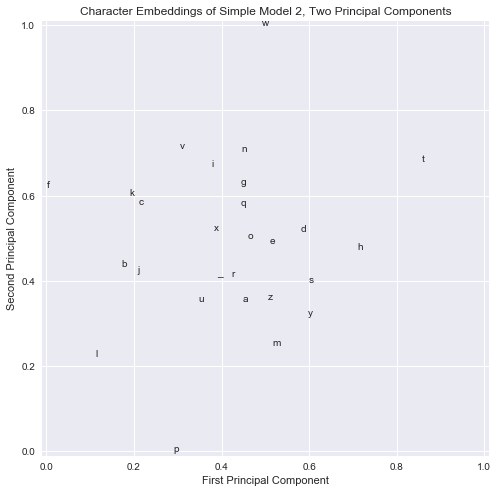

In [72]:
f, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-.01, 1.01])
ax.set_ylim([-.01, 1.01])
for char, i in char_mapping.items():
    x, y = embedding_matrix_2_dim[i]
    ax.text(x, y, char)

ax.set_title('Character Embeddings of Simple Model 2, Two Principal Components')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')

I can't really see any obvious patterns, except possibly that k and c are very close. 
I had hopes that characters that are close by on the keyboard would appear close in the embedding, as these characters are supposedly often interchanged in spelling errors. 
This is true for a few characters, but far from all.